<a href="https://colab.research.google.com/github/KhondamirRustamov/Neyron_tizimlarga-Kirish/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22omegafold_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**OmegaFold**
for more details see: [Github](https://github.com/HeliXonProtein/OmegaFold), [Preprint](https://www.biorxiv.org/content/10.1101/2022.07.21.500999v1)

#### **Tips and Instructions**
- click the little ▶ play icon to the left of each cell below.
- use "/" to specify chainbreaks, (eg. sequence="AAA/AAA")


**Omegafold + MSA by Ovchinnikov**

In [ ]:
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 1000

# Learning rate for optimizers
lr = 0.0001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [4]:

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 5, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 5 x 5
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 5, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 10 x 10
            nn.ConvTranspose2d( ngf * 4, ngf * 2, (4,3), (1,2), (0,1), bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 10 x 20
            nn.ConvTranspose2d( ngf * 2, ngf, (4,3), (1,2), (0,1), bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 20 x 40
            nn.ConvTranspose2d( ngf, nc, (4,3), (1,2), (0,1), bias=False),
            # state size. (nc) x 20 x 80
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
#@markdown ##Install

%%bash
if [ ! -d OmegaFold ]; then
  git clone --quiet https://github.com/sokrypton/OmegaFold.git
  cd OmegaFold
  pip -q install -r requirements.txt
  pip -q install py3Dmol
  apt-get install aria2 -qq > /dev/null
  aria2c -q -x 16 https://helixon.s3.amazonaws.com/release1.pt
  mkdir -p ~/.cache/omegafold_ckpt
  mv release1.pt ~/.cache/omegafold_ckpt/model.pt
fi

In [6]:
seeq = 'GSGSGSCVKWFIYGVIAVYICYTLIVHKRYQEKEELTSSVRVTLKGVAHVDRIWDAAEYTIPTQTRDSFFVMTNIIRTENQIQKTCPEYPTAKAICSSDKSCAKGIVDVHSNGVQTGKCVHYNITHKTCEIKAWCPVQGEERPPVPAVLRSSEDFTVFIKNNIHFPTFQYTVQNISPKLNTSCKFNKVTAPLCPIFRLGDILQEAKENFSEMAVKGGIIAIEIKWDCDLDSWSYYCSPEYSFRRLDDKTRTQYPGFSIRFARHYKLPDGTEQRTLFKAYGIRFDVLVFGMGGQFKLIELFTFIGSTIAYFGLAVTIIEMCFHLYNLE'
seeq[275:292]

'AYGIRFDVLVFGM'

In [7]:
%%time
#@markdown ##Run
import re
from string import ascii_uppercase, ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)


sequence = "AYGIRFDVLVFGM" #@param {type:"string"}
sequence = re.sub("[^A-Z\/\:]", "", sequence.upper()).replace("/",":")
lengths = [len(s) for s in sequence.split(":")]

num_cycle = 4 #@param ["1", "2", "4", "8", "16", "32"] {type:"raw"}

with open("tmp.fasta","w") as out:
  out.write(f">tmp\n{sequence}\n")
%shell python ./OmegaFold/main.py --num_cycle={num_cycle} tmp.fasta .

def renum_pdb_str(pdb_str, Ls=None, renum=True, offset=1):
  if Ls is not None:
    L_init = 0
    new_chain = {}
    for L,c in zip(Ls, alphabet_list):
      new_chain.update({i:c for i in range(L_init,L_init+L)})
      L_init += L  

  n,num,pdb_out = 0,offset,[]
  resnum_ = None
  chain_ = None
  new_chain_ = new_chain[0]
  for line in pdb_str.split("\n"):
    if line[:4] == "ATOM":
      chain = line[21:22]
      resnum = int(line[22:22+5])
      if resnum_ is None: resnum_ = resnum
      if chain_ is None: chain_ = chain
      if resnum != resnum_ or chain != chain_:
        num += (resnum - resnum_)  
        n += 1
        resnum_,chain_ = resnum,chain
      if Ls is not None:
        if new_chain[n] != new_chain_:
          num = offset
          new_chain_ = new_chain[n]
      N = num if renum else resnum
      if Ls is None: pdb_out.append("%s%4i%s" % (line[:22],N,line[26:]))
      else: pdb_out.append("%s%s%4i%s" % (line[:21],new_chain[n],N,line[26:]))        
  return "\n".join(pdb_out)

pdb_str = renum_pdb_str(open("tmp.pdb",'r').read(), Ls=lengths)
with open("tmp.pdb","w") as out:
  out.write(pdb_str)

/usr/local/lib/python3.7/dist-packages/Bio/Data/SCOPData.py:21: BiopythonDeprecationWarning: The 'Bio.Data.SCOPData' module will be deprecated in a future release of Biopython in favor of 'Bio.Data.PDBData.
  BiopythonDeprecationWarning,
INFO:root:Loading weights from /root/.cache/omegafold_ckpt/model.pt
INFO:root:Constructing OmegaFold
Traceback (most recent call last):
  File "./OmegaFold/main.py", line 106, in <module>
    main()
  File "/usr/local/lib/python3.7/dist-packages/torch/autograd/grad_mode.py", line 27, in decorate_context
    return func(*args, **kwargs)
  File "./OmegaFold/main.py", line 55, in main
    model.to(args.device)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 927, in to
    return self._apply(convert)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 579, in _apply
    module._apply(fn)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 579, in _apply
    module._a

CalledProcessError: ignored

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 3), stride=(1, 2), padding=(0, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 3), stride=(1, 2), padding=(0, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 3), stride=(1, 2), padding=(0, 1), bias=False)
  )
)


(1, 1, 20, 81)


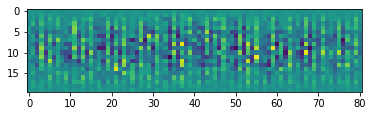

In [ ]:
%matplotlib inline
noise = torch.randn(1, nz, 1, 1, device=device)
fake = netG(noise)
plt.imshow(fake.cpu().detach().numpy()[0][0])
print(fake.cpu().detach().numpy().shape)

(20, 81)


(1, 1, 20, 81)

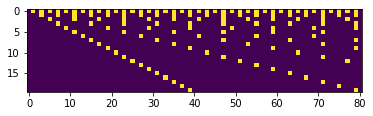

In [ ]:
from math import sqrt
target = np.zeros((20,81))
print(target.shape)

for i, c in enumerate(target):
  for x, z in enumerate(c):
    if (((x+1)/(i+1))**2)%4==0:
      target[i][x]=1.0

plt.imshow(target)
target1 = target.reshape((1,1,20,81))
target1.shape

In [ ]:
# Initialize BCELoss function
criterion = nn.MSELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
def renum_pdb_str(pdb_str, Ls=None, renum=True, offset=1):
  if Ls is not None:
    L_init = 0
    new_chain = {}
    for L,c in zip(Ls, alphabet_list):
      new_chain.update({i:c for i in range(L_init,L_init+L)})
      L_init += L  

  n,num,pdb_out = 0,offset,[]
  resnum_ = None
  chain_ = None
  new_chain_ = new_chain[0]
  for line in pdb_str.split("\n"):
    if line[:4] == "ATOM":
      chain = line[21:22]
      resnum = int(line[22:22+5])
      if resnum_ is None: resnum_ = resnum
      if chain_ is None: chain_ = chain
      if resnum != resnum_ or chain != chain_:
        num += (resnum - resnum_)  
        n += 1
        resnum_,chain_ = resnum,chain
      if Ls is not None:
        if new_chain[n] != new_chain_:
          num = offset
          new_chain_ = new_chain[n]
      N = num if renum else resnum
      if Ls is None: pdb_out.append("%s%4i%s" % (line[:22],N,line[26:]))
      else: pdb_out.append("%s%s%4i%s" % (line[:21],new_chain[n],N,line[26:]))        
  return "\n".join(pdb_out)

def omega_foldit(sequence):
  sequence = [re.sub("[^A-Z\/\:]", "", i.upper()).replace("/",":") for i in sequence]
  lengths = [[len(s) for s in i.split(":")] for i in sequence]

  num_cycle = 4
  for i in range(len(sequence)):
    with open(f"tmp{i}.fasta","w") as out:
      out.write(f">tmp{i}\n{sequence[i]}\n")
    %shell python ./OmegaFold/main.py --num_cycle={num_cycle} tmp{i}.fasta .
    pdb_str = renum_pdb_str(open(f"tmp{i}.pdb",'r').read(), Ls=lengths[i])
    with open(f"tmp{i}.pdb","w") as out:
      out.write(pdb_str)


aa = 'A R N D C E Q G H I L K M F P S T W Y V'
aminoacid_list = aa.split(' ')
a_dict={}
for i, aaa in enumerate(aminoacid_list):
  a_dict[aaa]=i



def numpy_to_seq(array, seq_len, oligomer=1):
  sequence = []
  receptor = 'VYYTCCPDTPYL'
  array = array.cpu().detach().numpy()
  for i in array:
    seq=''
    array_n = i[0]
    for i in array_n.T:
      z = np.argmax(i)
      seq+=aminoacid_list[z]
    seq = seq[:seq_len]
    seq = seq + ('/' + receptor)
    sequence.append(seq)
  return sequence


#target_a = np.load('hal.npy')


def take_loss(target_pdb_name, seq_len):
  all_loss = sum([take_loss1(f'{target_pdb_name}{i}.pdb') for i in range(seq_len)])/seq_len
  return torch.tensor(0).float(), torch.tensor(all_loss).float()

  '''
  def take_loss_assembly(target_pdb_name, oligomer, seq_len, hal_region):
    losses = []
    for i in range(seq_len):
      chains_z = open(f'{target_pdb_name}{i}.pdb','r').readlines()
      chains_z = [i.split(' ') for i in chains_z]
      chains_z = [[i for i in x if i!=''] for x in chains_z if len(x)!=0]
      chains_z = [np.array([(float(x)) for x in i[6:9]]) for i in chains_z if i[2]=='CA']
      chains_z = np.array(chains_z[hal_region[0]:hal_region[1]])
      atom_coord = []
      for i in range(oligomer):
        z1 = int(chains_z.shape[0]/oligomer)
        atom_coord += [chains_z[x] for x in range(z1*i, z1*(i+1))]
      atom_coord = np.array(atom_coord)
      atom_coord = squareform(pdist(atom_coord, metric='euclidean'))
      losses.append(atom_coord)
    losses = np.array(losses)
    return torch.tensor(losses).float()

  target3d = np.array([target_a for x in range(seq_len)])
  error1 = take_loss_assembly(target_pdb_name, oligomer, seq_len, hal_region)
  target = torch.tensor(target3d).float()
  return target, error1'''


def take_loss1(filename):
  with open(filename) as ifile:
      system = "".join([x for x in ifile])
  system1 = system.split("\n")
  system2 = []
  for x in system1:
    if x[:4] == 'ATOM':
      system2.append(x)
  CAS = [x for x in system2 if "CA" in x]
  CAS = [x.split(' ') for x in CAS]
  CAS = [[x for x in y if x!=''] for y in CAS ]
  CAS_A = [x for x in CAS if x[4]=='A']
  CAS_B = [x for x in CAS if x[4]=='B']
  CAS_A = np.array([np.array([float(x[6]), float(x[7]), float(x[8])]) for x in CAS_A])
  CAS_B = np.array([np.array([float(x[6]), float(x[7]), float(x[8])]) for x in CAS_B])
  loss = sum([sqrt(np.sum((CAS_A - i)**2))/CAS_A.shape[0] for i in CAS_B])/CAS_B.shape[0]
  return loss

In [ ]:
numpy_to_seq(fake, 25)

['VEYKYKSHVPDIVDKPVPDKYQILV/VYYTCCPDTPYL']

In [ ]:
import time
import re
from string import ascii_uppercase, ascii_lowercase

In [ ]:
# Training Loop
num_epochs = 10
# Lists to keep track of progress
img_list = []
G_losses = []
#tables=[]
iters = 0

print("Starting Training Loop...")
# For each epoch
netG.apply(weights_init)
for epoch in range(num_epochs):
      start = time.time()
    # For each batch in the dataloader
      noise = torch.randn(15, nz, 1, 1, device=device)

      fake = netG(noise)
      fake = numpy_to_seq(fake, 25)
      img_list.append(fake)
      omega_foldit(fake)
      print('time:', time.time()-start)
      optimizerG.zero_grad()
      
      # Calculate G's loss based on this output
      target, pred_loss = take_loss('tmp', 15)
      errG = criterion(target, pred_loss).requires_grad_(True)
      print(errG)
      # Calculate gradients for G
      errG.backward()
      # Update G
      optimizerG.step()
        
      # Output training stats
      print(f'{epoch+1}/{num_epochs}, {errG.item()}')
      #tables.append(fake.detach().numpy()[0][0])
      
      # Save Losses for plotting later
      G_losses.append(errG.item())
      
#tables.append(fake.detach().numpy()[0][0])

In [ ]:
min_seq = img_list[6]

In [ ]:
min_seq

['TIHPHICSLLDPLLNLGTKIMSGPS/VYYTCCPDTPYL',
 'GWMPKFPTQLQMMLGMHTFHHKCPC/VYYTCCPDTPYL',
 'IMCILIHPHMSMKGEKGMLSLGHIM/VYYTCCPDTPYL',
 'HWPPLEMIHMPMLLEMHTIFFECIK/VYYTCCPDTPYL',
 'PKCKLGTIMMSLKIKHLELIGGEPK/VYYTCCPDTPYL',
 'KEISLEEMPSKQMKIIQSNPHKEKM/VYYTCCPDTPYL',
 'PWPFHKCWTLPFQIFKLFGFMMQFL/VYYTCCPDTPYL',
 'HWHFFEHFIMPLIIDMPHHKHHMLM/VYYTCCPDTPYL',
 'KWCKLIPGMMDKLMDESKLPLKQIK/VYYTCCPDTPYL',
 'FCLKHDQKQWNMGCDHCIGMPKHKI/VYYTCCPDTPYL',
 'CKLMPKLMQQKGMCKILTCTPEGCK/VYYTCCPDTPYL',
 'KWGFTFHFPCLMKICHMWGSLQEPH/VYYTCCPDTPYL',
 'LGQFPICLCWKGMCSHMDHMMIHKK/VYYTCCPDTPYL',
 'QYKFHIMIILEKLDILLPIMQKLKK/VYYTCCPDTPYL',
 'FFFFQETKPIPEQHIIHKFSMKHPI/VYYTCCPDTPYL']

In [ ]:
omega_foldit(min_seq)

INFO:root:Loading weights from /root/.cache/omegafold_ckpt/model.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading tmp0.fasta
INFO:root:Predicting 1th chain in tmp0.fasta
INFO:root:37 residues in this chain.
INFO:root:Finished prediction in 9.59 seconds.
INFO:root:Saving prediction to ./tmp0.pdb
INFO:root:Saved
INFO:root:Done!
INFO:root:Loading weights from /root/.cache/omegafold_ckpt/model.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading tmp1.fasta
INFO:root:Predicting 1th chain in tmp1.fasta
INFO:root:37 residues in this chain.
INFO:root:Finished prediction in 9.80 seconds.
INFO:root:Saving prediction to ./tmp1.pdb
INFO:root:Saved
INFO:root:Done!
INFO:root:Loading weights from /root/.cache/omegafold_ckpt/model.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading tmp2.fasta
INFO:root:Predicting 1th chain in tmp2.fasta
INFO:root:37 residues in this chain.
INFO:root:Finished prediction in 9.53 seconds.
INFO:root:Saving prediction to ./tmp2.pdb
INFO:root:Saved
INFO:root:Done!
I

In [ ]:
target, pred_loss = take_loss('tmp', 2)
criterion(target, pred_loss).requires_grad_(True)

tensor(50.8756, requires_grad=True)

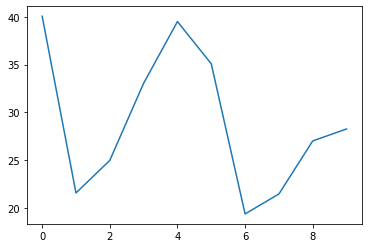

In [ ]:
plt.plot(G_losses)

In [ ]:
print(G_losses)

[40.06370162963867, 21.5516414642334, 24.966880798339844, 33.043128967285156, 39.50423049926758, 35.08546829223633, 19.355213165283203, 21.441282272338867, 27.001399993896484, 28.254167556762695]


In [ ]:
file = open('results.txt', 'w')

for i, x in zip(img_list, G_losses):
  file.write(str(x) + '\n')
  for iz in i:
    file.write(str(iz) + '\n')
file.close()

In [ ]:
img_list[3]

['ILILMHEFLSMSICLDMQKLIGPGLTKCPCKWNPM', 'DLMPGHPKMKLSSEEWQKGMQLCSHQGEMPMWIQK', 'GHLMKLMILSHLGEFKEFGLIHQGDFHHGFIRHLK', 'CHKQHHSICKPDFMGDIGFQMFHTDLMLKFKRQPQ', 'HQEMQDDWGHCMKDGKELFHGQMDKPHMFGQKQQG', 'DHKMKLIWLKLKQILPEHGMPECWEGFMLMHGQLI', 'DQLGPLMWISHILGFIQCQMPILKKKFIKKPWKTF', 'NHFLPDNWGIKMIGQEMILHPKMGCSFICMMFHLL', 'NFIPGLGFMSHNKKFYLSILQMLWIFGKQKIRHTE', 'FQFMFECKDSPMFIKGHTLMQQCLDKCPPGIIELM']


In [ ]:
from termcolor import colored

print colored('hello', 'red'), colored('world', 'green')

In [ ]:
noise = torch.randn(1, nz, 1, 1, device=device)

fake = netG(noise)

fake = fake.cpu().detach().numpy()[0][0]

seq=''
for i in fake.T:
  z = np.argmax(i)
  seq+=aminoacid_list[z]

print(seq)

SLLFMFIYLLPLLKGSHCLVPCFMQFPIFKKGVTQLLKKSLLKHWLKSMHKNMKHKMAPPMSIFLLMMPSHLGIPWTIIKQ


In [ ]:
array = img_list[0].cpu().detach().numpy()[0][0]
p = [np.argmax(x) for x in array.T]
p

In [ ]:
img_list

[['EGMQHMFLPHNMQGDMWMTFLPKCK/VYYTCCPDTPYL',
  'IKNICFWQCMFQGHPMSQPCKESGI/VYYTCCPDTPYL'],
 ['QHKFGDFDISNHFHHIHQPFLLEML/VYYTCCPDTPYL',
  'HQSQWGHQHLFLCQDLPINIGPWLH/VYYTCCPDTPYL']]

In [ ]:
def get_the_best_model():
  n = int(np.argmin(np.array(G_losses)))
  seq = img_list[n]
  return seq

In [ ]:
array = img_list[-3]

In [ ]:
omega_foldit('FGRIIANRIIRIGRII')

INFO:root:Loading weights from /root/.cache/omegafold_ckpt/model.pt
INFO:root:Constructing OmegaFold
INFO:root:Reading tmp.fasta
INFO:root:Predicting 1th chain in tmp.fasta
INFO:root:16 residues in this chain.
INFO:root:Finished prediction in 38.05 seconds.
INFO:root:Saving prediction to ./tmp.pdb
INFO:root:Saved
INFO:root:Done!


In [ ]:
!pip install py3Dmol

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import py3Dmol

In [ ]:
def atom_shaper(a):
  coord = []
  for i in range(1000):
    x = round(random.uniform(-a, a), 3)
    y = round(random.uniform(-a, a), 3)
    z = round(random.uniform(-a, a), 3)
    sq = sqrt(x**2 + y**2 + z**2)
    if sq <= a:
      coord.append([x,y,z])
  return coord

In [ ]:
pdb_string = atom_shaper(4)
f = open('sphere.pdb', 'w')
for i, value in enumerate(pdb_string):
  s = f'ATOM      {i}  H   H A   1      {value[0]}  {value[1]}  {value[2]}  10.00 38.12           H  \n'
  f.write(s)

In [ ]:
system3 = "".join([x+"\n" for x in system2[:1156]])

In [ ]:
with open('target.pdb', 'w') as file:
  file.write(system3)

In [ ]:
!pip install py3dmol

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import py3Dmol
with open("") as ifile:
    system = "".join([x for x in ifile])
view = py3Dmol.view(width=400, height=400)
view.addModelsAsFrames(system)
view.setStyle({},{"cartoon": {'color': 'spectrum'}})

#view.addSurface(py3Dmol.SAS, {'model': 0, 'chain': 'A', 'opacity': 0.9})
CA99 = [8.429,  67.609, -39.284]

#view.addBox({'center':{'x':[CA99[0]],'y':[CA99[1]],'z':[CA99[2]]},'dimensions': {'w':15,'h':15,'d':15},'color':'blue','opacity': 0.7})
#view.addSurface()
view.zoomTo()
view.show()

In [ ]:
import py3Dmol


pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):
  
  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    HP = ["ALA","GLY","VAL","ILE","LEU","PHE","MET","PRO","TRP","CYS","TYR"]
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_pdb(pdb_str, color=color, show_sidechains=show_sidechains, show_mainchains=show_mainchains,
         Ls=lengths).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
with open("tmp0.pdb") as ifile:
    system = "".join([x for x in ifile])
system1 = system.split("\n")
system2 = []
for x in system1:
  if x[:4] == 'ATOM':
    system2.append(x)

In [ ]:
file = open('pdb.txt', 'w')
for i in system2:
  file.write(i + '\n')

In [ ]:
system2[200]

'ATOM    201  N   LYS A  27      -0.478  -7.816  -6.808  1.00 45.91           N  '

In [ ]:
CAS = [x for x in system2 if "CA" in x]

In [ ]:
CAS

In [ ]:
CAS = [x.split(' ') for x in CAS]
CAS = [[x for x in y if x!=''] for y in CAS ]

In [ ]:
CAS[-1]

['ATOM',
 '367',
 'CA',
 'LEU',
 'B',
 '12',
 '-1.917',
 '7.155',
 '-14.299',
 '1.00',
 '35.52',
 'C']

In [ ]:
CAS_A = [x for x in CAS if x[4]=='A']
CAS_B = [x for x in CAS if x[4]=='B']

In [ ]:
for i in CAS_A:
  print(i)

In [ ]:
CAS_A = np.array([np.array([float(x[6]), float(x[7]), float(x[8])]) for x in CAS_A])
CAS_B = np.array([np.array([float(x[6]), float(x[7]), float(x[8])]) for x in CAS_B])

In [ ]:
CAS_A

In [ ]:
from math import sqrt

In [ ]:
CAS_B.shape

(12, 3)

In [ ]:
sum([sqrt(np.sum((CAS_A - i)**2))/CAS_A.shape[0] for i in CAS_B])/CAS_B.shape[0]

8.918727452607685

In [ ]:
def take_loss(filename):
  with open(filename) as ifile:
      system = "".join([x for x in ifile])
  system1 = system.split("\n")
  system2 = []
  for x in system1:
    if x[:4] == 'ATOM':
      system2.append(x)
  CAS = [x for x in system2 if "CA" in x]
  CAS = [x.split(' ') for x in CAS]
  CAS = [[x for x in y if x!=''] for y in CAS ]
  CAS_A = [x for x in CAS if x[4]=='A']
  CAS_B = [x for x in CAS if x[4]=='B']
  CAS_A = np.array([np.array([float(x[6]), float(x[7]), float(x[8])]) for x in CAS_A])
  CAS_B = np.array([np.array([float(x[6]), float(x[7]), float(x[8])]) for x in CAS_B])
  loss = sum([sqrt(np.sum((CAS_A - i)**2))/CAS_A.shape[0] for i in CAS_B])/CAS_B.shape[0]
  return loss

In [ ]:
%%time
take_loss('tmp.pdb')

CPU times: user 2.37 ms, sys: 29 µs, total: 2.4 ms
Wall time: 2.33 ms


2.5109469971087885

In [ ]:
from scipy.spatial.distance import pdist, squareform
from math import sqrt


def take_loss_assembly(target_pdb_name, oligomer, seq_len, hal_region):
    losses = []
    for i in range(seq_len):
      chains_z = open(f'{target_pdb_name}{i}.pdb','r').readlines()
      chains_z = [i.split(' ') for i in chains_z]
      chains_z = [[i for i in x if i!=''] for x in chains_z if len(x)!=0]
      chains_z = [np.array([(float(x)) for x in i[6:9]]) for i in chains_z if i[2]=='CA']
      chains_z = np.array(chains_z[hal_region[0]:hal_region[1]])
      atom_coord = []
      for i in range(oligomer):
        z1 = int(chains_z.shape[0]/oligomer)
        atom_coord += [chains_z[x] for x in range(z1*i, z1*(i+1))]
      atom_coord = np.array(atom_coord)
      atom_coord = squareform(pdist(atom_coord, metric='euclidean'))
      losses.append(atom_coord)
    losses = np.array(losses)
    return torch.tensor(losses).float()

In [ ]:
atom_coord = np.array(CAS_F)
atom_coord = squareform(pdist(atom_coord, metric='euclidean'))
np.save('hal.npy', atom_coord)

In [ ]:
plt.imshow(atom_coord)

In [ ]:
sheet = take_loss_assembly('tmp', 1, 1, (0, -1))

In [ ]:
plt.imshow(sheet[0])

In [ ]:
plt.imshow(atom_coord-sheet[0].cpu().detach().numpy())
print(criterion(torch.Tensor(atom_coord).float(),sheet[0]))

In [ ]:
hal_region = (27, 38)
chains_z = open(f'tmp0.pdb','r').readlines()
chains_z = [i.split(' ') for i in chains_z]
chains_z = [[i for i in x if i!=''] for x in chains_z if len(x)!=0]
chains_z = [np.array([(float(x)) for x in i[6:9]]) for i in chains_z if i[2]=='CA']
chains_z = np.array(chains_z[hal_region[0]:hal_region[1]])

In [ ]:
atom_coord = []
for i in range(1):
      z1 = int(chains_z.shape[0]/1)
      atom_coord += [chains_z[x] for x in range(z1*i, z1*(i+1))]

In [ ]:
atom_coord = np.array(atom_coord)
atom_coord = squareform(pdist(atom_coord, metric='euclidean'))

In [ ]:
plt.imshow(atom_coord)

In [ ]:
!pip install Bio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 270 kB 4.3 MB/s 
